In [ ]:
#https://www.kaggle.com/datasets/ashimstha/lettuce-health-compiled-dataset
#https://www.kaggle.com/datasets/ashishjstar/lettuce-diseases

In [ ]:
!pip install gdown --quiet gdown

In [ ]:
!unzip /content/lettuce_health_dataset.zip -d /content/

Archive:  /content/lettuce_health_dataset.zip
  inflating: /content/plant-health/healthy/20230619-1.jpg  
  inflating: /content/plant-health/healthy/20230619-2.jpg  
  inflating: /content/plant-health/healthy/20230619-4.jpg  
  inflating: /content/plant-health/healthy/20230619-6.jpg  
  inflating: /content/plant-health/healthy/20230619-9.jpg  
  inflating: /content/plant-health/healthy/20230622104115.jpg  
  inflating: /content/plant-health/healthy/20230622104140.jpg  
  inflating: /content/plant-health/healthy/20230622104158.jpg  
  inflating: /content/plant-health/healthy/20230622104231.jpg  
  inflating: /content/plant-health/healthy/20230622104253.jpg  
  inflating: /content/plant-health/healthy/20230622104549.jpg  
  inflating: /content/plant-health/healthy/20230622104605.jpg  
  inflating: /content/plant-health/healthy/20230622104622.jpg  
  inflating: /content/plant-health/healthy/20230622104701.jpg  
  inflating: /content/plant-health/healthy/20230622104711.jpg  
  inflating: /

In [ ]:
from keras.utils import image_dataset_from_directory
from keras.applications import ResNet101, VGG19, EfficientNetV2B0, ResNet50, MobileNetV3Small
from keras import models, layers
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import Model

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from PIL import Image
from IPython.display import display

import tensorflow as tf
import matplotlib.pyplot as plt
import os
import math
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

### 1. Lettuce health classification

In [ ]:
BATCH_SIZE=16
EPOCHS=30
VAL_SPLIT=0.2
TEST_SIZE=0.3
IMAGE_SIZE=224
DATA_PATH = '/content/plant-health'
CLASS_NAMES = os.listdir(DATA_PATH)

In [ ]:
print('healthy image: ', len(os.listdir(DATA_PATH + '/healthy')))
print('unhealthy image: ', len(os.listdir(DATA_PATH + '/unhealthy')))

healthy image:  326
unhealthy image:  381


In [ ]:
# Load image_path and label
image_paths = []
labels = []

for class_name in os.listdir(DATA_PATH):
    for img in os.listdir(f'{DATA_PATH}/{class_name}'):
        image_paths.append(f'{DATA_PATH}/{class_name}/{img}')
        labels.append(class_name)

df = pd.DataFrame({"image_path": image_paths, "class": labels})

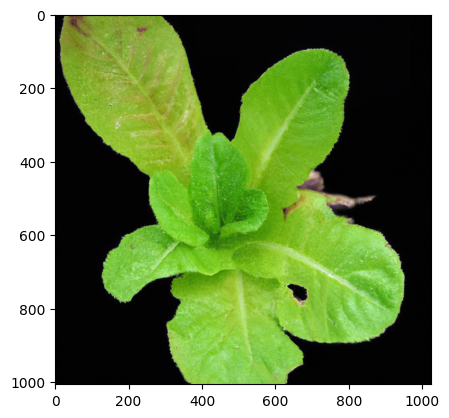

In [ ]:
image = Image.open(df['image_path'][0]).convert('RGB')
plt.imshow(image)
plt.show()

In [ ]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
vgg19.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
block1_conv1 có shape: (1, 224, 224, 64)


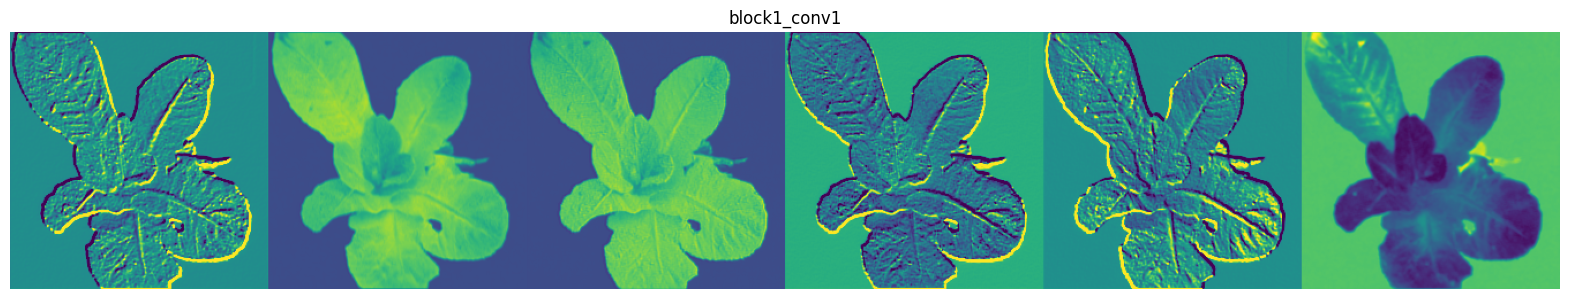

block1_conv2 có shape: (1, 224, 224, 64)


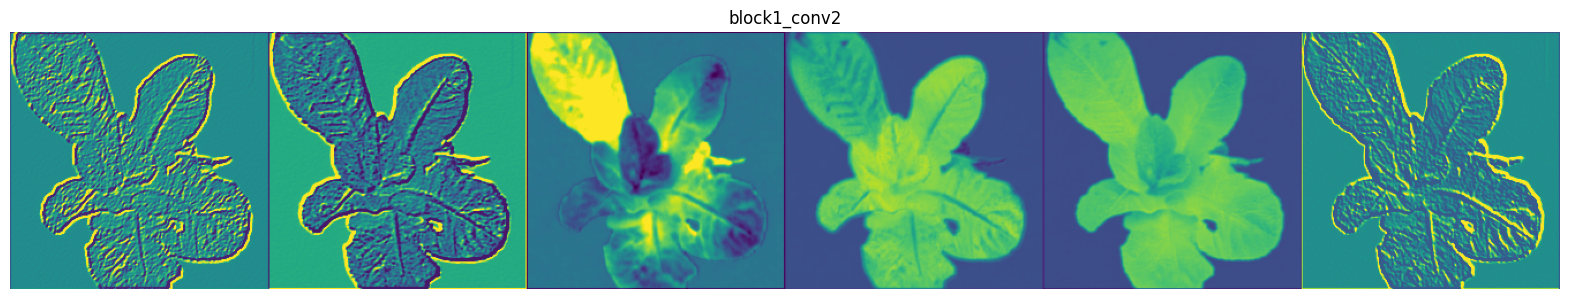

block2_conv2 có shape: (1, 112, 112, 128)


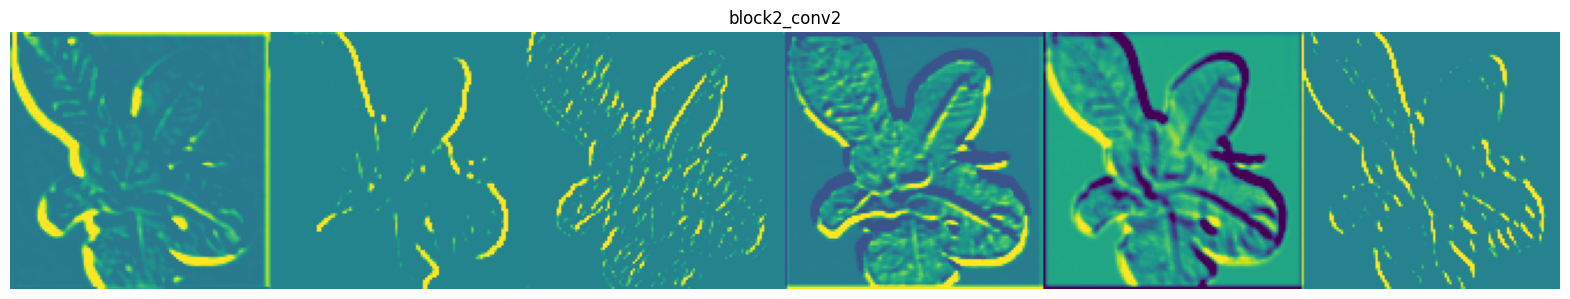

block3_conv4 có shape: (1, 56, 56, 256)


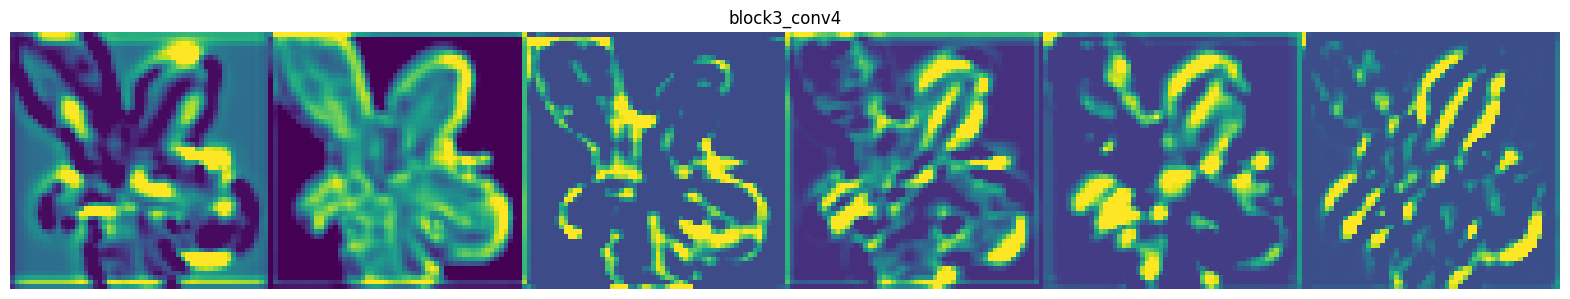

block4_conv4 có shape: (1, 28, 28, 512)


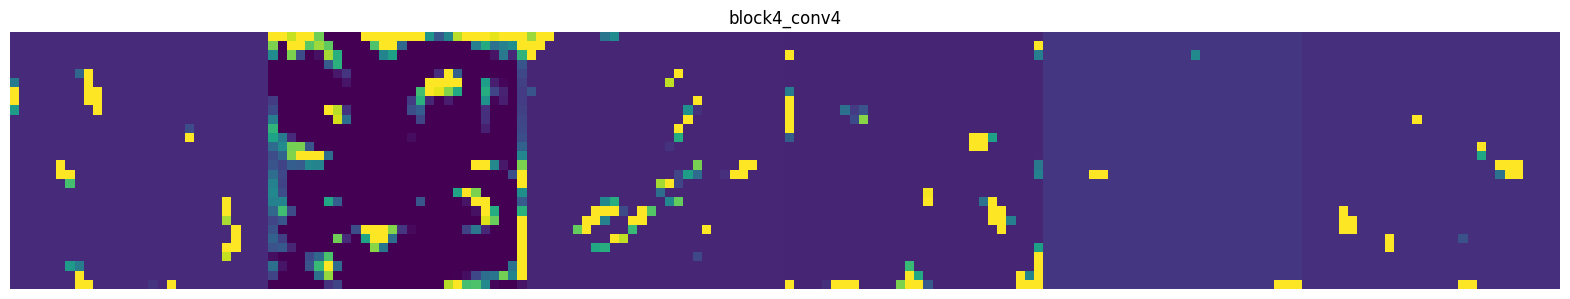

block5_conv4 có shape: (1, 14, 14, 512)


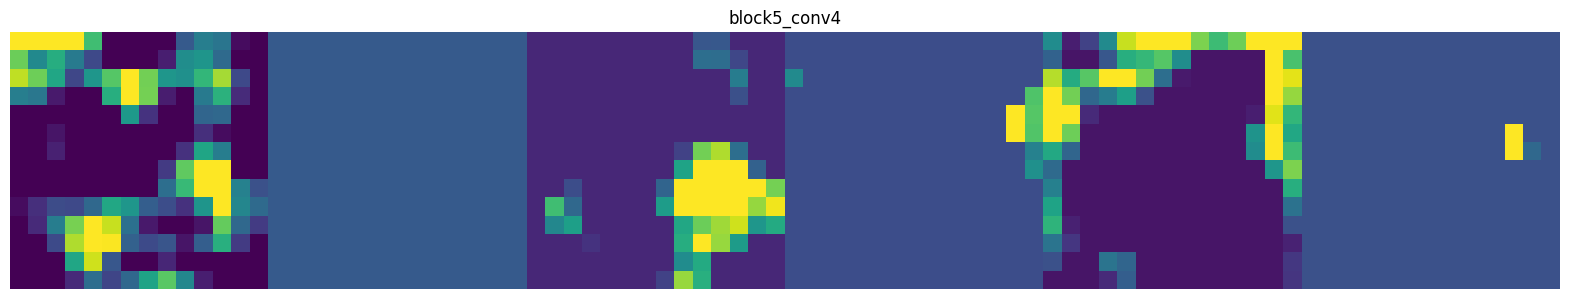

In [ ]:
IMAGE_SIZE = 224

image = Image.open(df['image_path'][0]).convert('RGB')
image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
img_array = np.array(image) / 255.0
img_array = np.expand_dims(img_array, axis=0)

vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

layer_names = [
    'block1_conv1',
    'block1_conv2',
    'block2_conv2',
    'block3_conv4',
    'block4_conv4',
    'block5_conv4'
]

outputs = [vgg19.get_layer(name).output for name in layer_names]
feature_model = Model(inputs=vgg19.input, outputs=outputs)
features = feature_model.predict(img_array)

def visualize_feature_maps(features, layer_names, n_channels=6):
    for fmap, layer_name in zip(features, layer_names):
        print(f"{layer_name} có shape: {fmap.shape}")
        size = fmap.shape[1]
        display_grid = np.zeros((size, size * n_channels))

        for i in range(n_channels):
            channel = fmap[0, :, :, i]
            channel -= channel.mean()
            channel /= (channel.std() + 1e-5)
            channel *= 64
            channel += 128
            channel = np.clip(channel, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = channel

        scale = 20. / n_channels
        plt.figure(figsize=(scale * n_channels, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.axis('off')
        plt.show()

visualize_feature_maps(features, layer_names)

In [ ]:
def create_model():
    base_model = VGG19(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights="imagenet")
    # base_model.trainable=False
    # for layer in base_model.layers[-4:]:
    #     layer.trainable=True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(rate=0.5),
        layers.Dense(1, activation='sigmoid')
        ])

    return model
create_model().summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,090,177 (76.64 MB)

 Trainable params: 20,090,177 (76.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Khoi tao k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

val_datagen = ImageDataGenerator(rescale=1./255)

fold_idx=1
histories=[]
best_val_acc=0

for train_index, val_index in kf.split(image_paths, labels):
    print(f'====================================================================')
    print(f'                              Folk {fold_idx}')
    print(f'====================================================================')

    df_train = df.iloc[train_index]
    df_val = df.iloc[val_index]

    train_gen = train_datagen.flow_from_dataframe(
        df_train,
        x_col='image_path',
        y_col='class',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        color_mode='rgb',
        classes=CLASS_NAMES,
    )

    val_gen = val_datagen.flow_from_dataframe(
        df_val,
        x_col='image_path',
        y_col='class',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        color_mode='rgb',
        classes=CLASS_NAMES,
    )

    model_kfold=create_model()

    model_kfold.compile(loss=BinaryCrossentropy(),
                        optimizer=Adam(learning_rate=1e-5),
                        metrics=['accuracy'])

    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * math.exp(-0.1)

    earlystopping=callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    lr_schedule=callbacks.LearningRateScheduler(scheduler)

    history = model_kfold.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[earlystopping, lr_schedule]
    )

    val_acc = max(history.history['val_accuracy'])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model_kfold

    histories.append(history)
    fold_idx += 1

                              Folk 1
Found 565 validated image filenames belonging to 2 classes.
Found 142 validated image filenames belonging to 2 classes.
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 35s 711ms/step - accuracy: 0.5055 - loss: 0.7316 - val_accuracy: 0.7113 - val_loss: 0.6337 - learning_rate: 1.0000e-05
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 555ms/step - accuracy: 0.5924 - loss: 0.6642 - val_accuracy: 0.6620 - val_loss: 0.6229 - learning_rate: 1.0000e-05
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 542ms/step - accuracy: 0.6878 - loss: 0.5808 - val_accuracy: 0.8521 - val_loss: 0.4118 - learning_rate: 1.0000e-05
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 547ms/step - accuracy: 0.7643 - loss: 0.5062 - val_accuracy: 0.7465 - val_loss: 0.4739 - learning_rate: 1.0000e-05
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 547ms/step - accuracy: 0.8465 - loss: 0.3945 - val_accuracy: 0.8873 - val_loss: 0.2478 - learning_rate: 1.0000e-05
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 538ms/step - acc

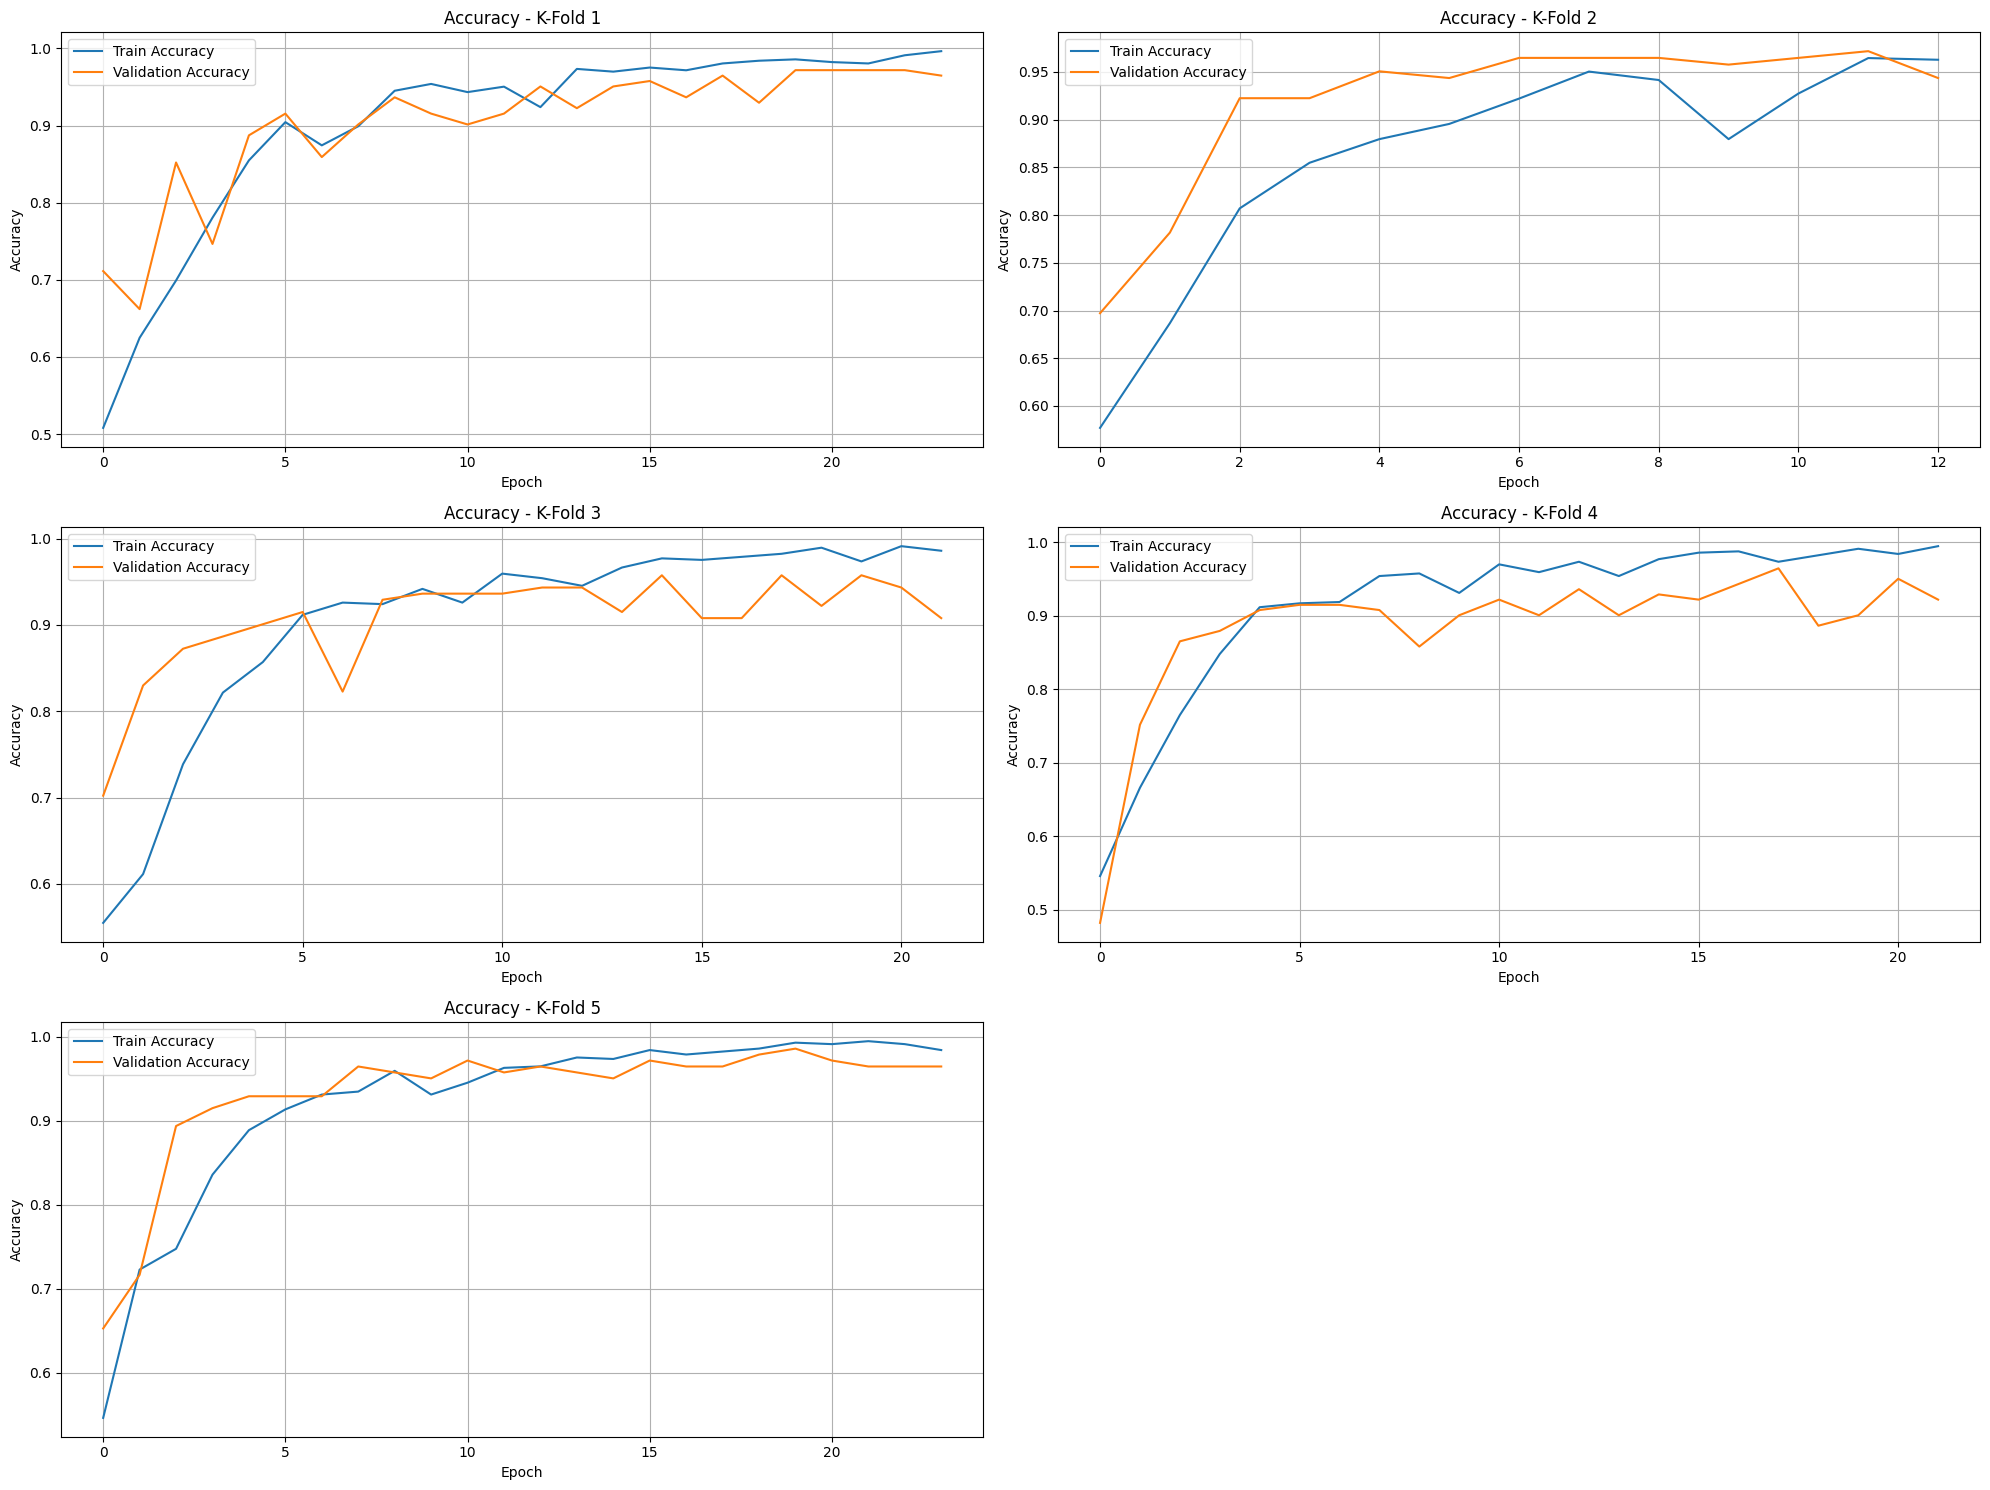

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
ax = ax.flatten()

for i, history in enumerate(histories):
    ax[i].plot(history.history['accuracy'], label='Train Accuracy')
    ax[i].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[i].set_title(f'Accuracy - K-Fold {i+1}')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy')
    ax[i].legend()
    ax[i].grid(True)

for j in range(len(histories), len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [ ]:
_, test_df = train_test_split(df, test_size=TEST_SIZE, stratify=df['class'], random_state=42)

test_gen = ImageDataGenerator(rescale=1./255,).flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='class',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False,
        classes=CLASS_NAMES
)

Found 213 validated image filenames belonging to 2 classes.


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step
Accuracy score: 1.0

Classification report:
               precision    recall  f1-score   support

   unhealthy       1.00      1.00      1.00       115
     healthy       1.00      1.00      1.00        98

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213



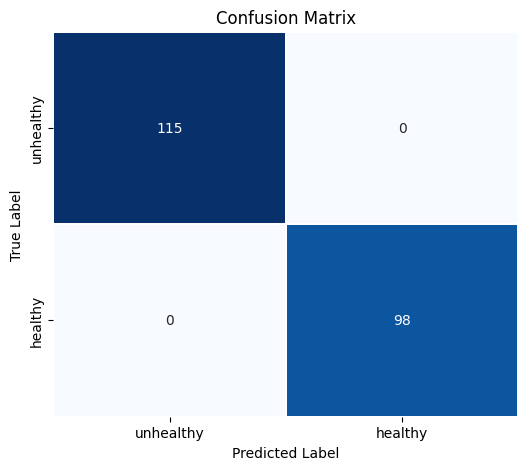

In [ ]:
y_true = test_gen.classes
y_pred = best_model.predict(test_gen, verbose=1)

y_pred_labels = (y_pred > 0.5).astype(int)
print("Accuracy score:", accuracy_score(y_true, y_pred_labels))
print("\nClassification report:\n", classification_report(y_true, y_pred_labels, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            linewidths=0.3, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
best_model.save('/content/lettuce_health_VGG19_classification.keras')

In [ ]:
import gdown

file_id = "1KR-qtCV5rOyz19ulFuhW967IBcDZttPY"
gdown.download(f"https://drive.google.com/uc?id={file_id}",
               "test_images.zip", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1KR-qtCV5rOyz19ulFuhW967IBcDZttPY
To: /content/test_images.zip
100%|██████████| 481k/481k [00:00<00:00, 108MB/s]


'test_images.zip'

In [ ]:
!unzip -q test_images.zip -d test_image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


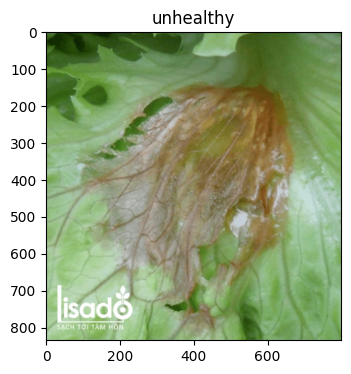

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


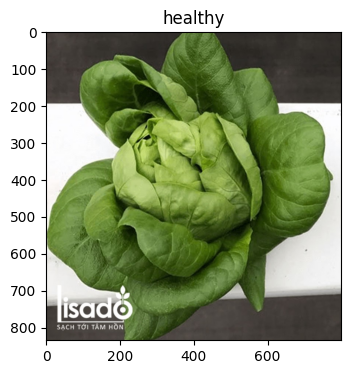

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


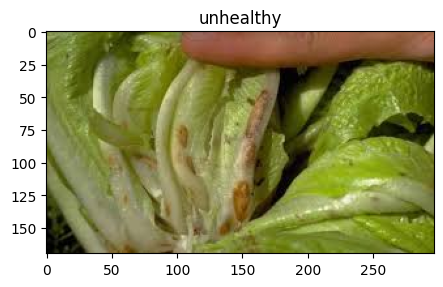

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


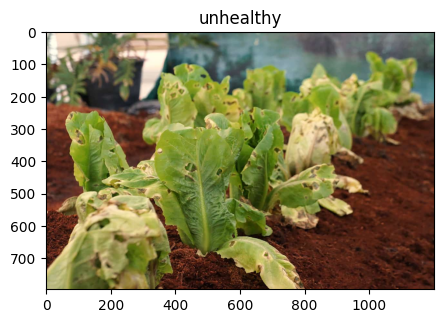

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


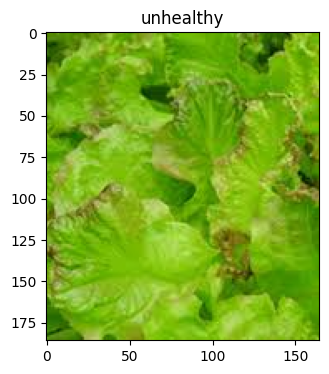

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


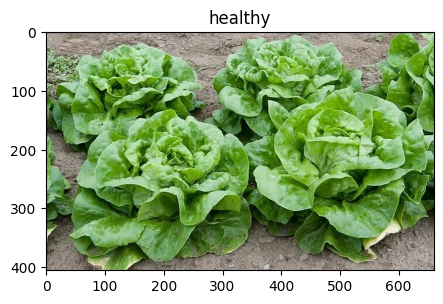

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


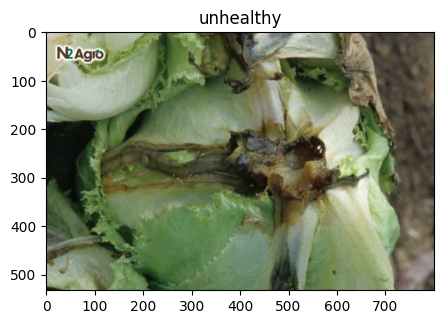

In [ ]:
test_path = '/content/test_image/test_lecttuce'
for img_name in os.listdir(test_path):
  org_image = Image.open(test_path +'/' + img_name).convert('RGB')
  image = org_image.resize((IMAGE_SIZE, IMAGE_SIZE))
  image = np.array(image)/ 255.0
  image = np.expand_dims(image, axis=0)

  pred = best_model.predict(image)
  y_pred_labels = (pred[0] > 0.5).astype(int)
  plt.figure(figsize=(5, 4))
  plt.imshow(org_image)
  plt.title(CLASS_NAMES[y_pred_labels[0]])
  plt.show()

### 2. Lettuce disease classification

In [ ]:
!unzip /content/Lettuce_disease_datasets.zip -d /content/

Archive:  /content/Lettuce_disease_datasets.zip
   creating: /content/Lettuce_disease_datasets/
   creating: /content/Lettuce_disease_datasets/Bacterial/
  inflating: /content/Lettuce_disease_datasets/Bacterial/bct (1).jpg  
  inflating: /content/Lettuce_disease_datasets/Bacterial/bct (10).jpg  
  inflating: /content/Lettuce_disease_datasets/Bacterial/bct (11).jpg  
  inflating: /content/Lettuce_disease_datasets/Bacterial/bct (12).jpg  
  inflating: /content/Lettuce_disease_datasets/Bacterial/bct (13).jpg  
  inflating: /content/Lettuce_disease_datasets/Bacterial/bct (14).jpg  
  inflating: /content/Lettuce_disease_datasets/Bacterial/bct (15).jpg  
  inflating: /content/Lettuce_disease_datasets/Bacterial/bct (16).jpg  
  inflating: /content/Lettuce_disease_datasets/Bacterial/bct (17).jpg  
  inflating: /content/Lettuce_disease_datasets/Bacterial/bct (18).jpg  
  inflating: /content/Lettuce_disease_datasets/Bacterial/bct (19).jpg  
  inflating: /content/Lettuce_disease_datasets/Bacteria

In [ ]:
from datetime import datetime
from keras.losses import CategoricalCrossentropy

In [ ]:
IMAGE_SIZE=224
TEST_SIZE=0.15
BATCH_SIZE=16
DATA_PATH = '/content/Lettuce_disease_datasets'
CLASS_NAMES = os.listdir(DATA_PATH)
EPOCHS=30

In [ ]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.2,
    horizontal_flip=True
)

def augmentation_image(name_dir, image):
    if name_dir == '/content/Lettuce_disease_datasets/Wilt_and_leaf_blight_on_lettuce':
        num = 7
    else:
        num = 4

    image = np.array(image)
    image = np.expand_dims(image, axis=0)

    aug_images = [image[0]]
    aug_iter = data_gen.flow(image, batch_size=1)

    for _ in range(num):
        aug_img_array = next(aug_iter)[0].astype(np.uint8)
        aug_img = Image.fromarray(aug_img_array)
        save_path = os.path.join(name_dir, f'{datetime.now().strftime("%Y%m%d_%H%M%S_%f")}.jpg')
        aug_img.save(save_path)
        print(f'Succed save: {save_path}')
    return

for class_name in os.listdir(DATA_PATH):
    name_dir = os.path.join(DATA_PATH, class_name)
    for img_file in os.listdir(name_dir):
        image = Image.open(os.path.join(name_dir, img_file)).convert('RGB')
        augmentation_image(name_dir, image)

Succed save: /content/Lettuce_disease_datasets/Bacterial/20251017_033733_264539.jpg
Succed save: /content/Lettuce_disease_datasets/Bacterial/20251017_033733_307786.jpg
Succed save: /content/Lettuce_disease_datasets/Bacterial/20251017_033733_349187.jpg
Succed save: /content/Lettuce_disease_datasets/Bacterial/20251017_033733_388000.jpg
Succed save: /content/Lettuce_disease_datasets/Bacterial/20251017_033733_410702.jpg
Succed save: /content/Lettuce_disease_datasets/Bacterial/20251017_033733_428878.jpg
Succed save: /content/Lettuce_disease_datasets/Bacterial/20251017_033733_446732.jpg
Succed save: /content/Lettuce_disease_datasets/Bacterial/20251017_033733_465306.jpg
Succed save: /content/Lettuce_disease_datasets/Bacterial/20251017_033733_500133.jpg
Succed save: /content/Lettuce_disease_datasets/Bacterial/20251017_033733_529432.jpg
Succed save: /content/Lettuce_disease_datasets/Bacterial/20251017_033733_559157.jpg
Succed save: /content/Lettuce_disease_datasets/Bacterial/20251017_033733_586

In [ ]:
image_paths = []
labels = []

for class_name in os.listdir(DATA_PATH):
    for img in os.listdir(f'{DATA_PATH}/{class_name}'):
        image_paths.append(f'{DATA_PATH}/{class_name}/{img}')
        labels.append(class_name)

df_disease = pd.DataFrame({"image_path": image_paths, "class": labels})

In [ ]:
def create_model():
    base_model = VGG19(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights="imagenet")

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(rate=0.5),
        layers.Dense(6, activation='softmax')
        ])

    return model
create_model().summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,090,822 (76.64 MB)

 Trainable params: 20,090,822 (76.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Khoi tao k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_idx=1
histories=[]
best_val_acc=0

for train_index, val_index in kf.split(image_paths, labels):
    print(f'====================================================================')
    print(f'                              Folk {fold_idx}')
    print(f'====================================================================')

    df_train = df_disease.iloc[train_index]
    df_val = df_disease.iloc[val_index]

    train_set = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        df_train,
        x_col='image_path',
        y_col='class',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        classes=CLASS_NAMES,
    )

    val_set = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        df_val,
        x_col='image_path',
        y_col='class',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        classes=CLASS_NAMES,
    )

    model_kfold=create_model()

    model_kfold.compile(loss=CategoricalCrossentropy(),
                        optimizer=Adam(learning_rate=1e-5),
                        metrics=['accuracy'])

    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * math.exp(-0.1)

    earlystopping=callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    lr_schedule=callbacks.LearningRateScheduler(scheduler)

    history = model_kfold.fit(
        train_set,
        validation_data=val_set,
        epochs=EPOCHS,
        callbacks=[earlystopping, lr_schedule]
    )

    val_acc = max(history.history['val_accuracy'])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_disease_model = model_kfold

    histories.append(history)
    fold_idx += 1

                              Folk 1
Found 446 validated image filenames belonging to 6 classes.
Found 112 validated image filenames belonging to 6 classes.
Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2582 - loss: 1.8678 - val_accuracy: 0.2679 - val_loss: 1.6585 - learning_rate: 1.0000e-05
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 383ms/step - accuracy: 0.2923 - loss: 1.6755 - val_accuracy: 0.3661 - val_loss: 1.6059 - learning_rate: 1.0000e-05
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - accuracy: 0.4298 - loss: 1.5279 - val_accuracy: 0.4018 - val_loss: 1.3833 - learning_rate: 1.0000e-05
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 380ms/step - accuracy: 0.4948 - loss: 1.3001 - val_accuracy: 0.6071 - val_loss: 1.2447 - learning_rate: 1.0000e-05
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 394ms/step - accuracy: 0.5874 - loss: 1.1646 - val_accuracy: 0.5625 - val_loss: 1.1673 - learning_rate: 1.0000e-05
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 395ms/step - accura

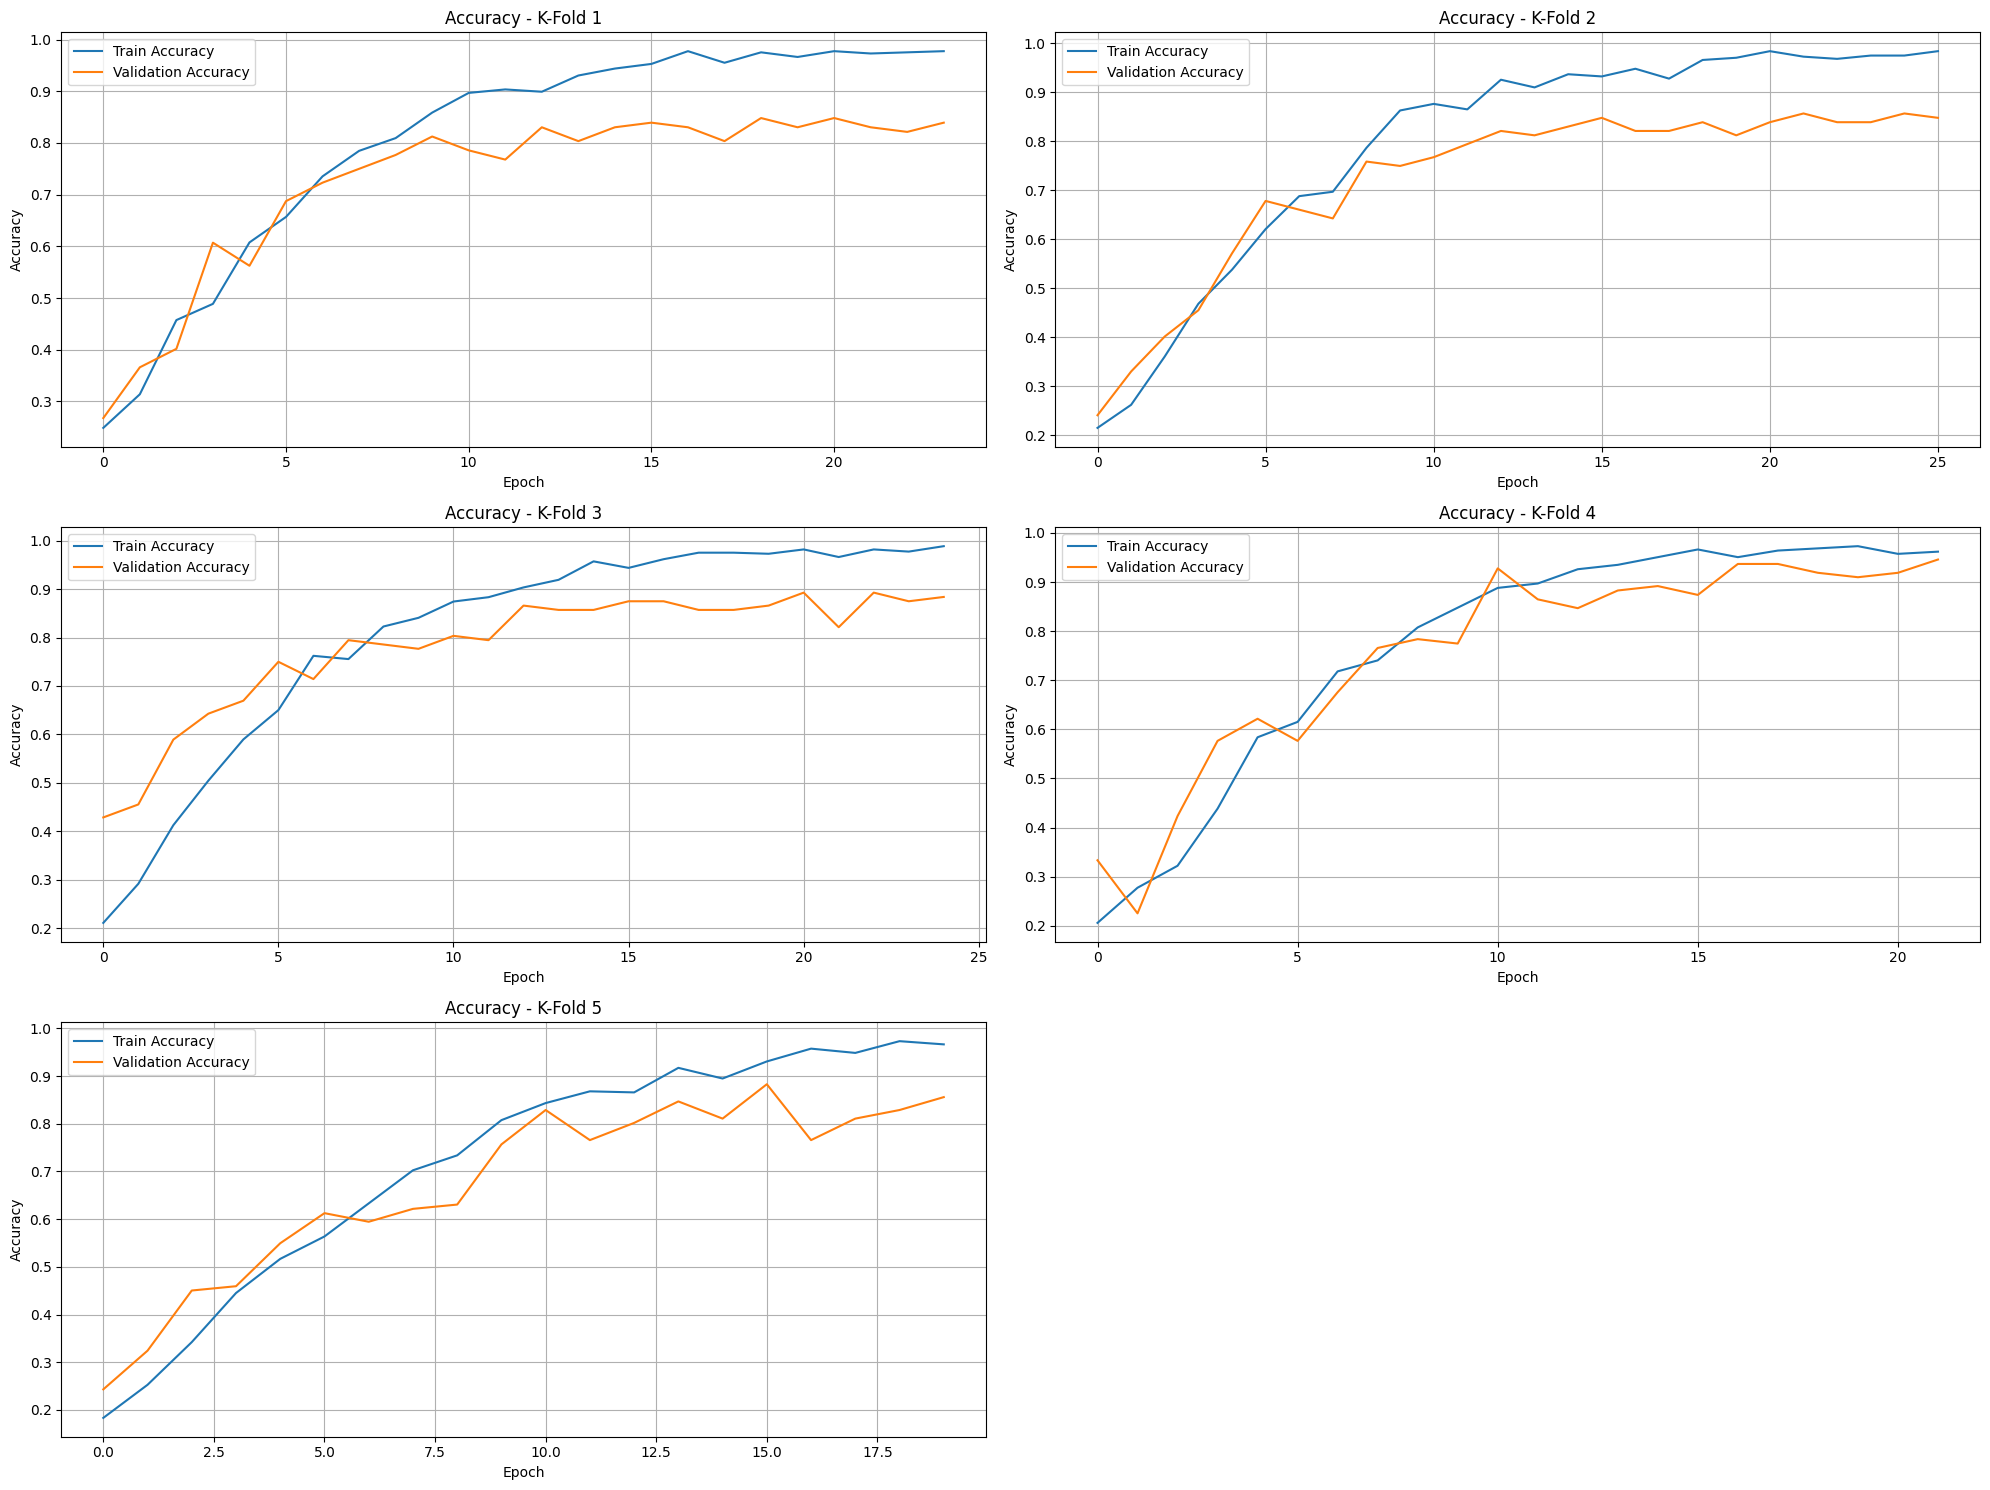

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
ax = ax.flatten()

for i, history in enumerate(histories):
    ax[i].plot(history.history['accuracy'], label='Train Accuracy')
    ax[i].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[i].set_title(f'Accuracy - K-Fold {i+1}')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy')
    ax[i].legend()
    ax[i].grid(True)

for j in range(len(histories), len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [ ]:
_, test_df = train_test_split(df, test_size=0.4, stratify=df['class'], random_state=42)

test_set = ImageDataGenerator(rescale=1./255,).flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='class',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        classes=CLASS_NAMES
)

Found 224 validated image filenames belonging to 6 classes.


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
Accuracy score: 0.9866071428571429

Classification report:
                                  precision    recall  f1-score   support

                      Bacterial       1.00      1.00      1.00        40
        Downy_mildew_on_lettuce       1.00      0.97      0.98        60
                          Viral       0.94      1.00      0.97        30
      Powdery_mildew_on_lettuce       0.97      1.00      0.99        36
Wilt_and_leaf_blight_on_lettuce       1.00      0.95      0.97        20
     Septoria_blight_on_lettuce       1.00      1.00      1.00        38

                       accuracy                           0.99       224
                      macro avg       0.99      0.99      0.99       224
                   weighted avg       0.99      0.99      0.99       224



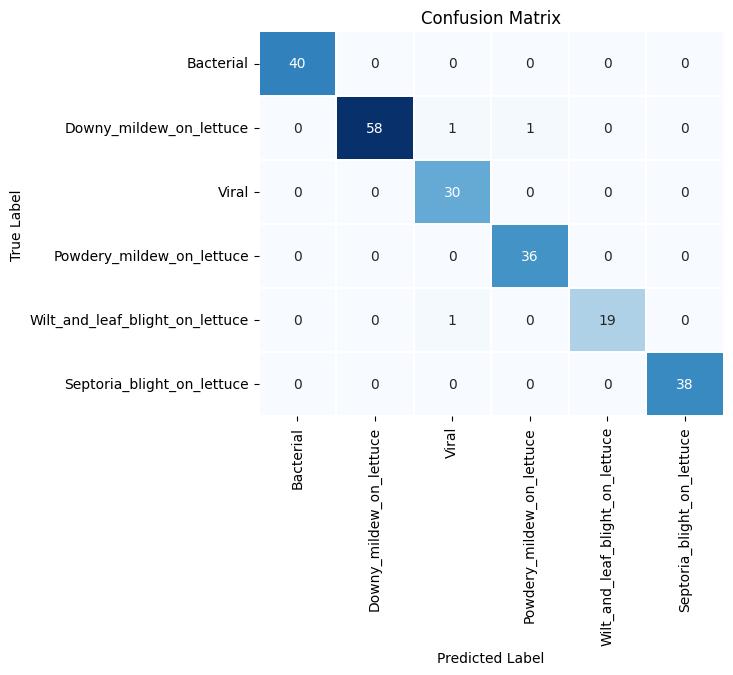

In [ ]:
y_true = test_set.classes
y_pred = best_disease_model.predict(test_set, verbose=1)

pred = np.argmax(y_pred, axis=1)
print("Accuracy score:", accuracy_score(y_true, pred))
print("\nClassification report:\n", classification_report(y_true, pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            linewidths=0.3, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
best_disease_model.save('lettuce_disease_vgg19_classification.keras')

In [ ]:
!unzip /content/disease_lettuce.zip -d /content/

Archive:  /content/disease_lettuce.zip
   creating: /content/disease_lettuce/
  inflating: /content/disease_lettuce/1_bacterial.jpg  
  inflating: /content/disease_lettuce/9_bacterial.jpg  
  inflating: /content/disease_lettuce/11_Downy_mildew.jpg  
  inflating: /content/disease_lettuce/2_Powdery_mildew.jpg  
  inflating: /content/disease_lettuce/3_Downy_mildew.jpg  
  inflating: /content/disease_lettuce/4_bacterial.jpg  
  inflating: /content/disease_lettuce/120_Powdery_mildew.jpg  
  inflating: /content/disease_lettuce/7_Septoria_blight.jpg  
  inflating: /content/disease_lettuce/5_Septoria_blight.jpg  
  inflating: /content/disease_lettuce/132_Viral.jpeg  
  inflating: /content/disease_lettuce/8_Downy_mildew.jpg  
  inflating: /content/disease_lettuce/1231_Viral.jpeg  


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
[[3.8084682e-04 9.4682598e-01 3.6503596e-04 4.4146504e-06 9.7244949e-05
  5.2326497e-02]]


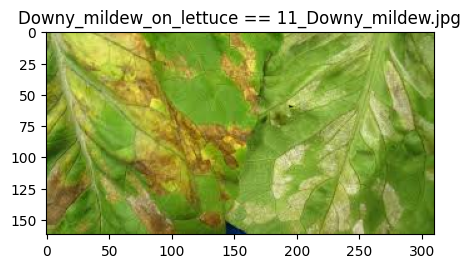

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[9.9994743e-01 7.3081660e-06 1.3569790e-05 1.4125401e-07 1.3847885e-07
  3.1500920e-05]]


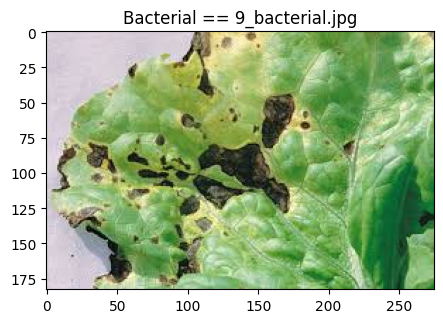

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[[8.4343906e-03 3.4088938e-05 2.0898872e-03 3.8967454e-01 5.9619439e-01
  3.5726693e-03]]


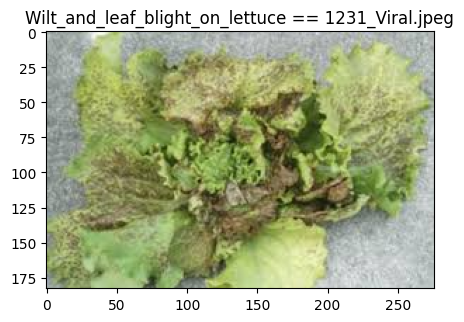

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
[[1.5919980e-03 9.9384093e-01 3.4259970e-03 2.3444691e-04 1.6705735e-06
  9.0507971e-04]]


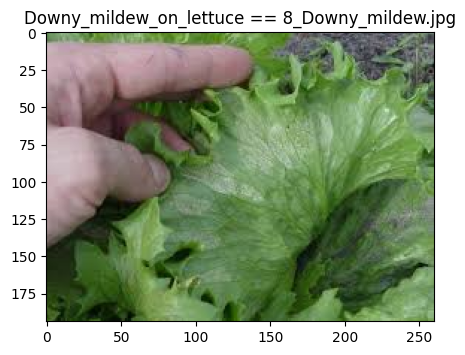

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[[9.9519330e-01 9.9426205e-04 1.7546623e-03 1.9806167e-03 1.6832271e-05
  6.0298917e-05]]


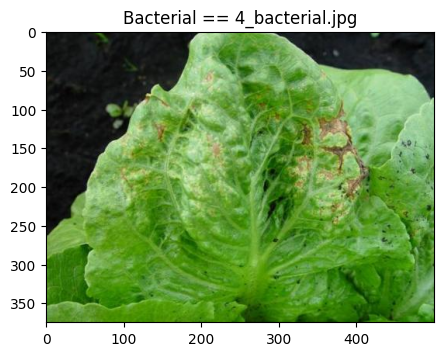

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
[[7.5295414e-03 1.0432354e-03 6.5632129e-01 3.3471552e-01 3.7802587e-04
  1.2340956e-05]]


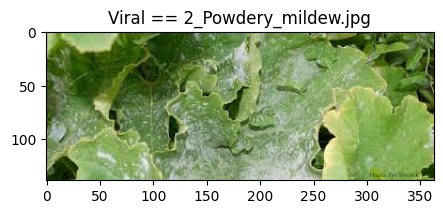

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[[4.1004097e-01 2.8944440e-04 3.6720019e-02 3.7089321e-01 1.6101637e-01
  2.1040035e-02]]


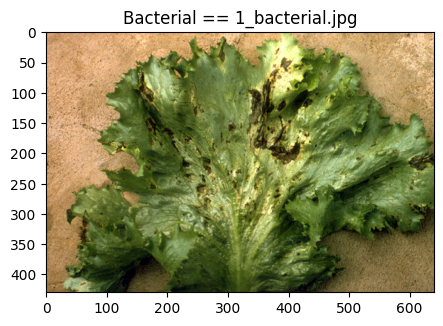

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[[2.3337333e-04 1.0001323e-06 2.6504347e-08 1.3799194e-08 1.4434433e-07
  9.9976546e-01]]


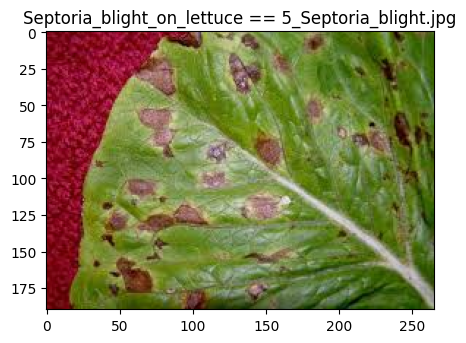

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[1.0669960e-07 9.9930120e-01 6.9743302e-04 1.8773983e-07 4.8481508e-07
  4.7813700e-07]]


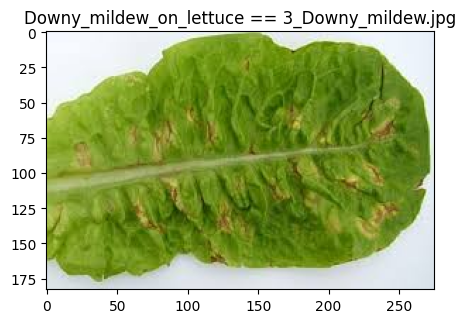

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[[4.3929376e-07 6.0567589e-05 8.5302268e-04 3.0556570e-05 9.9904901e-01
  6.4416240e-06]]


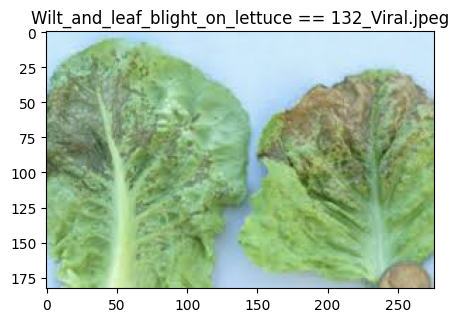

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[[0.19972585 0.00082162 0.0126269  0.100744   0.6424885  0.04359322]]


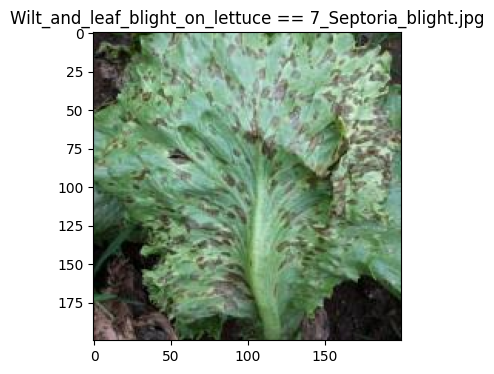

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[[3.7943708e-05 2.5353744e-05 1.3842246e-04 9.9510372e-01 4.6849940e-03
  9.6032018e-06]]


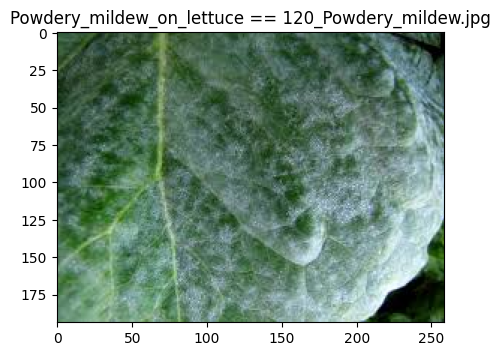

In [ ]:
for img in os.listdir('/content/disease_lettuce'):
  org_image = Image.open(f'/content/disease_lettuce/{img}').convert('RGB')
  image = org_image.resize((IMAGE_SIZE, IMAGE_SIZE))
  image = np.array(image)/ 255.0
  image = np.expand_dims(image, axis=0)

  pred = best_disease_model.predict(image)
  print(pred)
  pred_id = np.argmax(pred, axis=1)
  plt.figure(figsize=(5, 4))
  plt.imshow(org_image)
  plt.title(f'{CLASS_NAMES[pred_id[0]]} == {img}')
  plt.show()